# EnKF

In [1]:
import time
import scipy.stats
from matplotlib import pyplot as plt
import numpy as np


def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    logRdt = theta[:, 0] * rabbit - theta[:, 1] * rabbit * fox
    logFdt = theta[:, 2] * rabbit * fox - theta[:, 3] * fox
    return np.stack([logRdt, logFdt], axis=1)


enkf_ls = np.zeros((100, 240, 4))
time_ls = np.zeros(100)
obs_per_day = 12
days = 20
for EachRep in range(100):
    print(EachRep)
    start_time = time.time()
    SEED = np.random.randint(1, 100000)
    np.random.seed(SEED)
    yobs = np.load('LV observations.npy')[EachRep]
    ydata = yobs.copy()
    tvecObs = np.arange(0, days, 1 / obs_per_day)
    tvecFull = np.arange(0, days, 1 / obs_per_day)
    yFull = ydata.copy()
    xInitExogenous = np.zeros_like(yFull)
    for j in range(ydata.shape[1]):
        xInitExogenous[:, j] = np.interp(tvecFull, tvecObs, ydata[:, j])

    noise = 0.2
    dim_x = 2
    dim_theta = 4
    prior_mean_x0 = np.array([yFull[0, 0], yFull[0, 1]])
    prior_variance_x0 = np.diag([noise ** 2, noise ** 2])
    prior_mean_theta = np.array([0.6, 0.75, 1. ,1.])
    prior_variance_theta = np.diag([1, 1, 1, 1])
    var_obs_error = np.diag([noise ** 2, noise ** 2])
    outlier_threshold = 0.03

    theta_roaming_variance_unit_time = np.diag([0.1, 0.1, 0.1, 0.1])

    simulation_size = 100000
    samples_x = np.zeros(shape=[yFull.shape[0], simulation_size, dim_x])
    samples_theta = np.zeros(shape=[yFull.shape[0], simulation_size, dim_theta])

    init_samples_x = np.random.multivariate_normal(prior_mean_x0, prior_variance_x0, simulation_size)
    init_samples_theta = np.random.multivariate_normal(prior_mean_theta, prior_variance_theta, simulation_size)

    samples_x[0] = init_samples_x
    samples_theta[0] = init_samples_theta

    for k in range(1, yFull.shape[0]):
        delta_t = tvecFull[k] - tvecFull[k-1]

        samples_pred_theta = samples_theta[k-1] + np.random.multivariate_normal(np.zeros(dim_theta), theta_roaming_variance_unit_time * delta_t, simulation_size)
        samples_pred_theta = np.asarray(scipy.stats.mstats.winsorize(samples_pred_theta, outlier_threshold))

        samples_pred_x = samples_x[k-1] + delta_t * fOde(samples_pred_theta, samples_x[k-1])
        samples_pred_x = np.asarray(scipy.stats.mstats.winsorize(samples_pred_x, outlier_threshold))

        if not np.any(np.isfinite(yFull[k, :])):
            samples_x[k] = samples_pred_x
            samples_theta[k] = samples_pred_theta
        else:
            yobs = yFull[k, :]

            # stochastic updates
            samples_obs_error = np.random.normal(0, noise, samples_pred_x.shape)
            samples_pred_y = samples_pred_x + samples_obs_error

            var_pred_y = np.cov(samples_pred_x.transpose()) + var_obs_error
            samples_pred_xtheta = np.hstack([samples_pred_x, samples_pred_theta])
            cov_pred_xtheta_y = np.cov(samples_pred_xtheta.transpose())[:, :dim_x]

            idx_yobs = np.isfinite(yobs)
            yobs = yobs[idx_yobs]
            var_pred_y = var_pred_y[idx_yobs, :][:, idx_yobs]
            cov_pred_xtheta_y = cov_pred_xtheta_y[:, idx_yobs]
            samples_pred_y = samples_pred_y[:, idx_yobs]

            invvar_pred_y = np.linalg.inv(var_pred_y)

            samples_pred_xtheta = samples_pred_xtheta + (cov_pred_xtheta_y @ invvar_pred_y @ (yobs.reshape([1,-1]) - samples_pred_y).transpose()).transpose()

            samples_x[k] = samples_pred_xtheta[:, :dim_x]
            samples_theta[k] = samples_pred_xtheta[:, dim_x:]
    enkf_ls[EachRep] = np.mean(samples_theta, axis=1)
    time_ls[EachRep] = time.time() - start_time

print(np.mean(time_ls), np.std(time_ls))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
25.736541082859038 1.6178070211591578


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


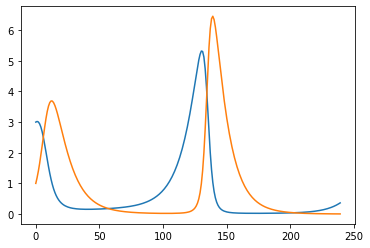

In [2]:
all_alpha = enkf_ls[:, :, 0]
all_beta = enkf_ls[:, :, 1]
all_delta = enkf_ls[:, :, 2]
all_gamma = enkf_ls[:, :, 3]

days = 20  
obs_per_day = 12
nobs = 240
X = np.arange(0, days, 1./obs_per_day)
true_alpha = 0.6 + 0.3 * np.cos(6.28 * X / 10)
true_beta = 0.75 * np.ones(nobs)
true_delta = np.ones(nobs)
true_gamma = 1 + 0.1 * np.sin(6.28 * X / 10)

def recover_data(alpha, beta, delta, gamma, state0=[3., 1.], days=20, obs_per_day=12, linspace=1000):
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.zeros((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha[index] * state_ls[i - 1][0] - beta[index] * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta[index] * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]

    return states

true_x = recover_data(true_alpha, true_beta, true_delta, true_gamma)
plt.plot(true_x[:, 0])
plt.plot(true_x[:, 1])

all_reconstructed_x = np.zeros((100, 240, 2))
for i in range(100):
    print(i)
    all_reconstructed_x[i] = recover_data(all_alpha[i], all_beta[i], all_delta[i], all_gamma[i], state0=[3., 1.])

Text(0.5, 1.0, 'Predator')

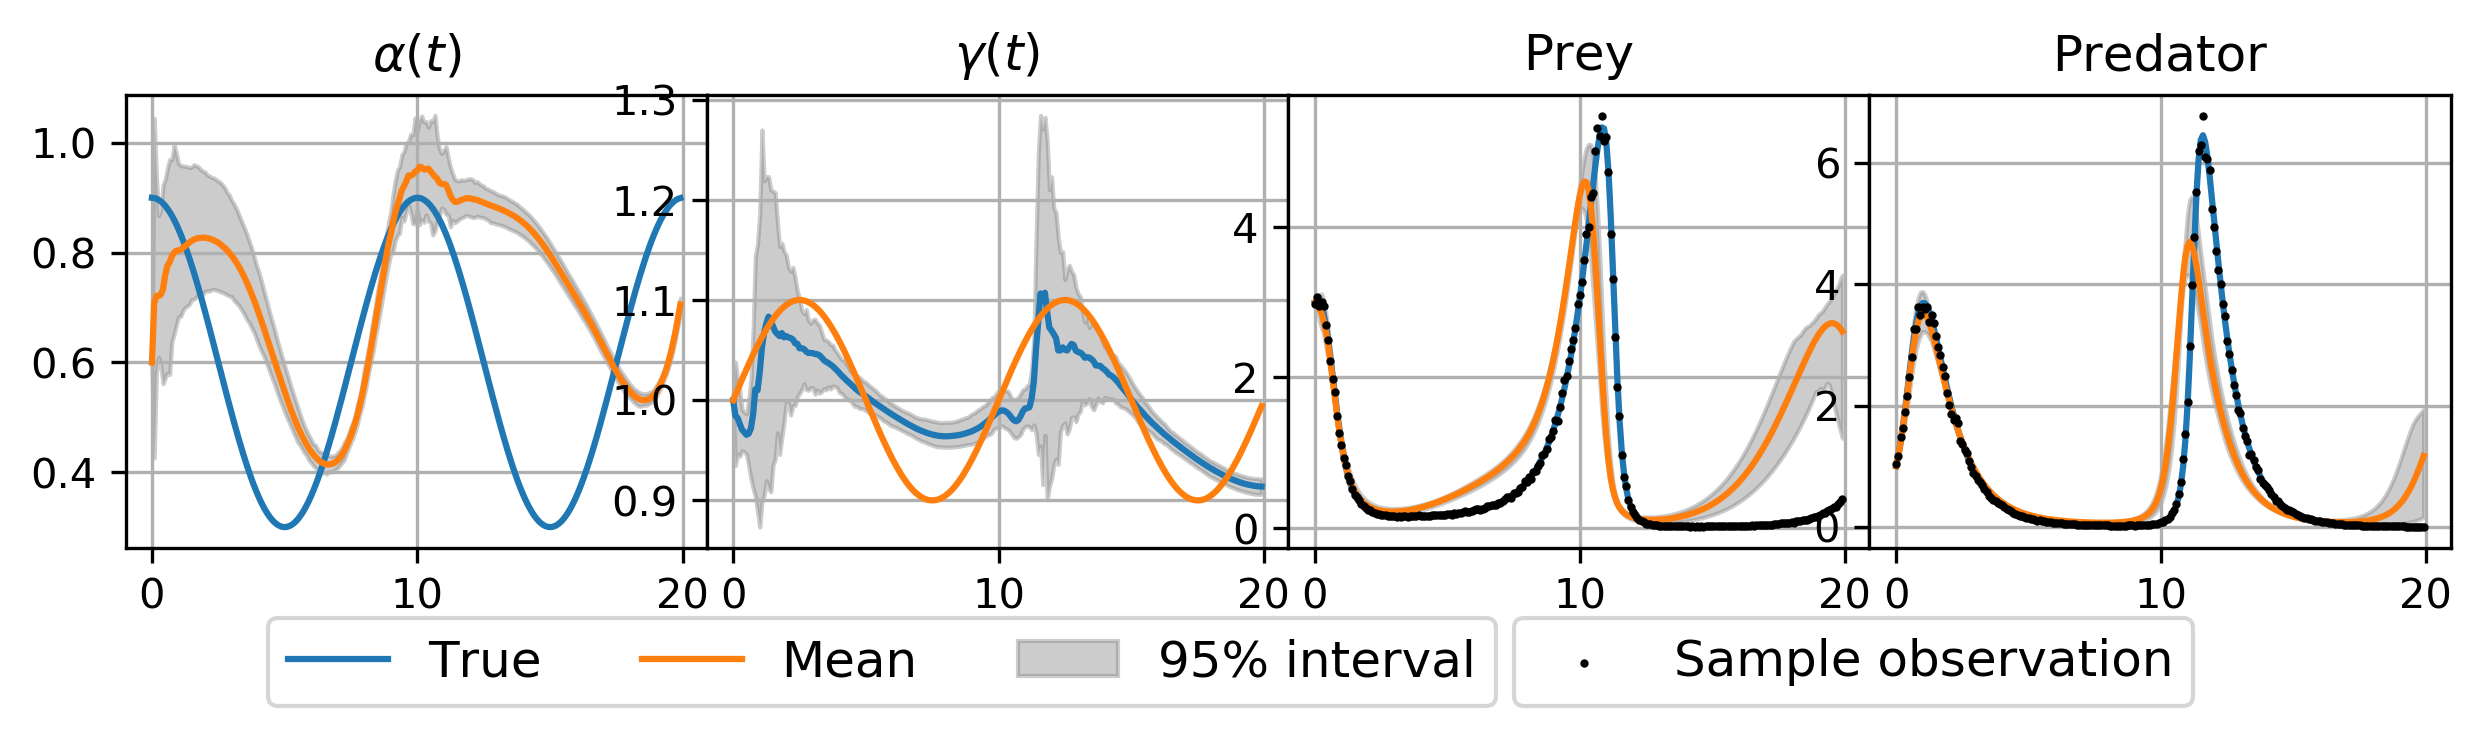

In [3]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # set figsize
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_alpha, 97.5, axis=0)
upper_95 = np.percentile(all_alpha, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(x, true_alpha, label='True')
plt.plot(x, np.mean(all_alpha, axis=0), label='Mean')
plt.title(r'$\alpha(t)$')
plt.grid()
plt.legend(bbox_to_anchor=(2.4, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(all_gamma, 97.5, axis=0)
upper_95 = np.percentile(all_gamma, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_gamma, axis=0))
plt.plot(x, true_gamma)
plt.grid()
plt.title(r'$\gamma(t)$')

yobs = np.load('G:/TVMAGI-LV/LV observations.npy')[1]
ax1 = plt.subplot(1, 4, 3) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_reconstructed_x[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 0], 2.5, axis=0)
x = np.arange(0, 20, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, 20, 1 / obs_per_day), true_x[:, 0])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 0], axis=0))
plt.scatter(np.arange(0, 20, 1 / obs_per_day), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('Prey')
plt.legend(bbox_to_anchor=(1.6, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 4)
lower_95 = np.percentile(all_reconstructed_x[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 1], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, 20, 1 / obs_per_day), true_x[:, 1])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 1], axis=0))
plt.scatter(np.arange(0, 20, 1 / obs_per_day), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('Predator')

Text(0.5, 1.0, '$\\gamma(t)$')

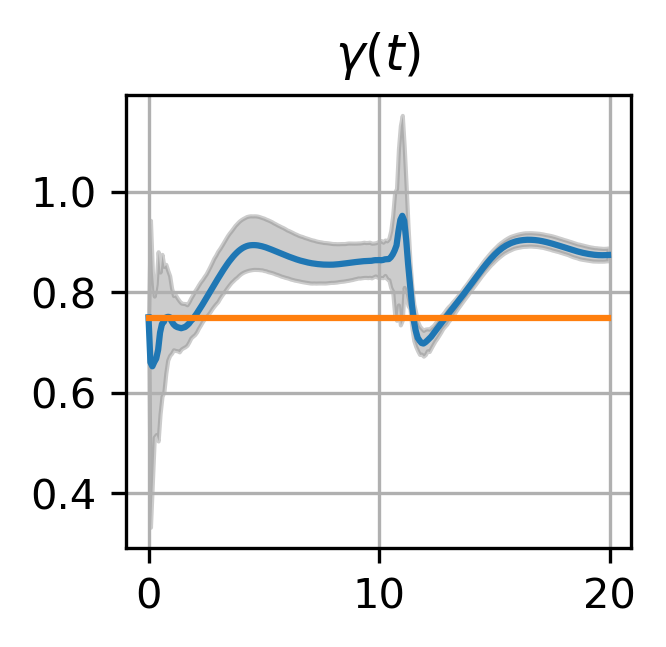

In [4]:
ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(all_beta, 97.5, axis=0)
upper_95 = np.percentile(all_beta, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_beta, axis=0))
plt.plot(x, true_beta)
plt.grid()
plt.title(r'$\gamma(t)$')

# RMSE

In [5]:
RMSE_alpha = np.sqrt(np.mean(np.square(all_alpha - true_alpha), axis=0))
print(np.mean(RMSE_alpha), np.std(RMSE_alpha))
RMSE_beta = np.abs(all_beta - true_beta)
print(np.mean(RMSE_beta), np.std(RMSE_beta))
RMSE_delta = np.abs(all_delta - true_delta)
print(np.mean(RMSE_delta), np.std(RMSE_delta))
RMSE_gamma = np.sqrt(np.mean(np.square(all_gamma - true_gamma), axis=0))
print(np.mean(RMSE_gamma), np.std(RMSE_gamma))

0.21361122801073182 0.14086839126109613
0.10141832482701564 0.05183764798088801
0.10433171710488379 0.04129357053787614
0.04364785638848947 0.02202902165325771


In [6]:
RMSE_R = np.zeros(100)
RMSE_F = np.zeros(100)
for i in range(100):
    RMSE_R[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, :, 0] - true_x[:, 0])))
    RMSE_F[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, :, 1] - true_x[:, 1])))
    
print(np.mean(RMSE_R), np.std(RMSE_R))
print(np.mean(RMSE_F), np.std(RMSE_F))

1.1080910797883954 0.07452692218275082
0.8627861977524063 0.07042822766665


In [10]:
theta_roaming_variance_unit_time

array([[0.1 , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.1 ]])